# Learning a model

##### Keywords: empirical risk minimization, bias, sampling distribution,  hypothesis space, law of large numbers, deterministic error, training error, out-of-sample error

## Contents
{:.no_toc}
*  
{: toc}

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

## TL;DR

We consider learning a function from data in the case where there is no measurement error and the collected data are enough to uniquley determine the value of the outcome variable.

We find that

- A model is selected by picking the "best" (in whatever sense) candidate out of a set of candidates (a hypothesis space). "Best" is often rephrased as "minimizes error".
- A particular hypothesis space may not be flexible enough to build a good model: the best candidate may still be bad
- The ultimate measure of our model is how well it predicts on the full population, not just our training sample
- When there's no noise, picking the model that does best on the training data tends to do well on the full data. The training points are samples from the full population, so minimizing training error ought to minimize full-data error, right?
- Right???

## The process of learning

Statisticians, scientists, machine learning gurus, MBAs and sometimes even politicians agree on the need to learn from data. But the question is: how and what does that mean?

Rather than bogging down in other kinds of learning, we'll focus on a sexy one: using observed data to predict the future. Specifically, we have a bunch of X,Y pairs and want to know: If I see a particular set of Xs, what would Y be?

The lessons from this context will generalize to other prediction problems.

For the moment, we're going to belive that the data are such that there's some function we could plug in to or some computation we could do that'll tell us the Y value of those inputs. The conceit is that we have such good data, so complete and with so little measurement error, that we can predict perfectly. Obviously, we'll be relaxing that assumption soon.

Since we want to predict the future, we want to figure out (learn) the above function via the data. We'll look at that process via a specific example.

### A real simple model
To gently step feet in the modelling world, lets see consider very simple model, where the percentage of people voting for Romney is a function only of how religious the population in a county is. This is a model I've cooked up, and the data is fake. [The thing we're predicting could equally well be the probability of the county voting for Romney, or average dollar donations to Romney in that county]

Let $x$ be the fraction of religious people in a county and $y$ be the percentage voting for Romney. In other words $y_i$ is data that pollsters have taken which tells us their estimate of percent of people voting for Romney and $x_i$ is the (likewise estimated) fraction of religious people in county $i$. In practice, because poll samples are finite, there is a margin of error on each data point or county $i$, but we will ignore that for now.

Let us assume that we have a "population" of 200 counties and the percent voting for Romney and percent religious in each of the counties:

In [3]:
df=pd.read_csv("data/religion.csv")
df.head()

,promney,rfrac
0,0.047790,0.00
1,0.051199,0.01
2,0.054799,0.02
3,0.058596,0.03
4,0.062597,0.04


Let's suppose now that the Lord came by and told us that the points in the plot below captures $f(x)$ exactly. This is the function whose formula we're trying to write down.

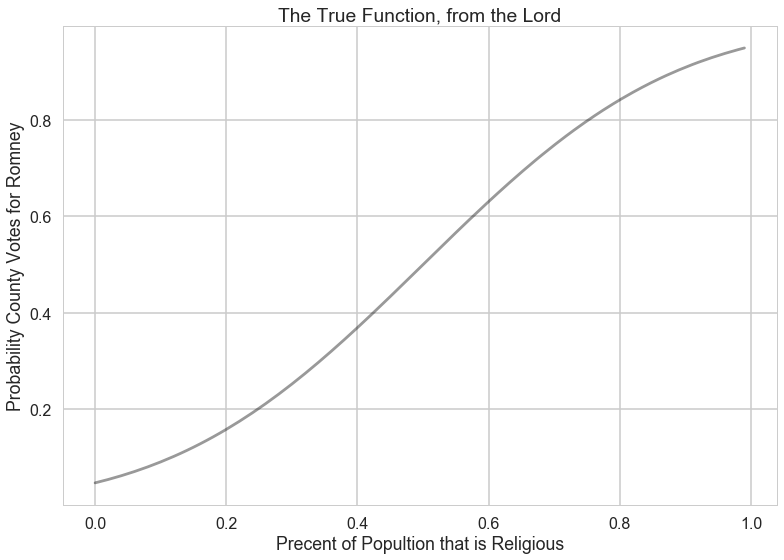

In [4]:
x=df.rfrac.values
f=df.promney.values
plt.plot(x,f, 'k-', alpha=0.4, label="f (from the Lord)");
plt.title("The True Function, from the Lord");
plt.xlabel("Precent of Popultion that is Religious")
plt.ylabel("Probability County Votes for Romney");

Since there's no measurement error, and religious fraction is enough to perfectly predict Romney fraction, the points in the plot below capture $f(x)$ exactly.

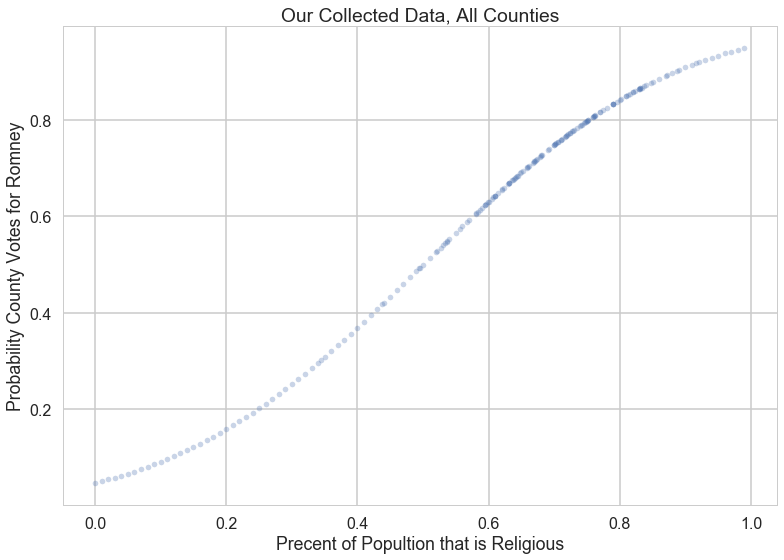

In [5]:
plt.plot(x,f,'.', alpha=0.3)
plt.title("Our Collected Data, All Counties")
plt.xlabel("Precent of Popultion that is Religious")
plt.ylabel("Probability County Votes for Romney");

Notice that our sampling of $x$ is not quite uniform: lots of counties happen to fall around an $x$ of 0.7.

#### Sampling
Sometimes in real life we have complete data (e.g. data on all counties in the US), but not often. In real life we typically only have a sample of points. Lets assume that out of this population of 200 points we are given a sample $\cal{D}$ of 30 data points. Such data is called **in-sample data**. Contrastingly, points not in our sample are called **out-of-sample data**.

In [6]:
dfsample = pd.read_csv("data/noisysample.csv")
dfsample.head()

,f,i,x,y
0,0.075881,7,0.07,0.138973
1,0.085865,9,0.09,0.050510
2,0.096800,11,0.11,0.183821
3,0.184060,23,0.23,0.057621
4,0.285470,33,0.33,0.358174


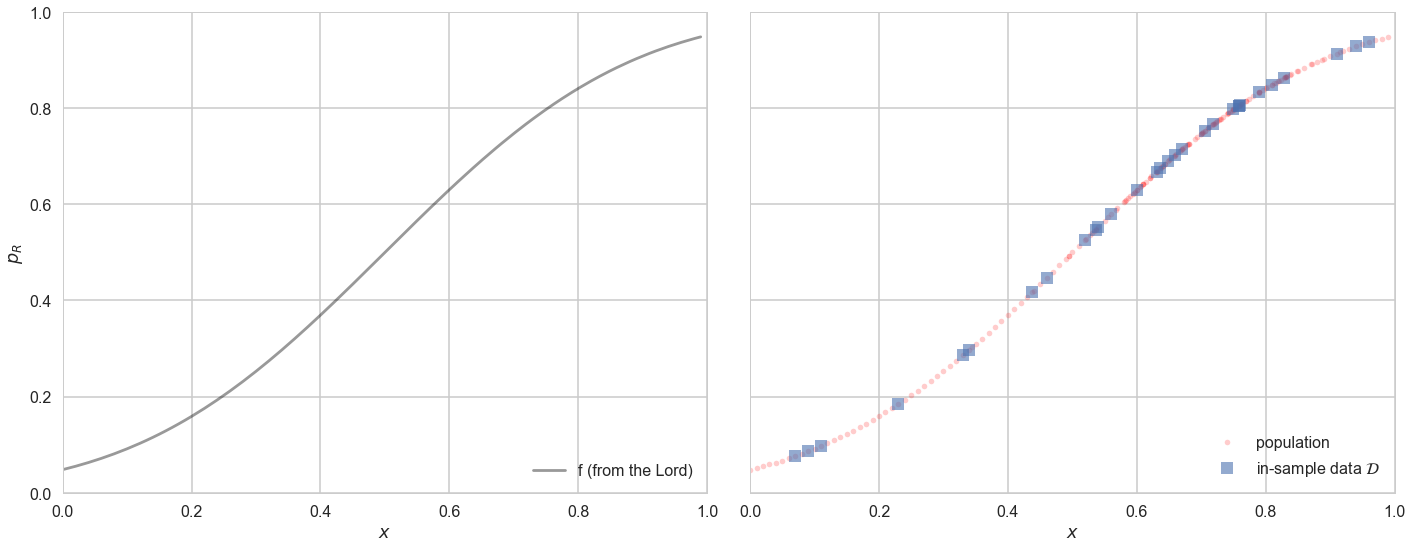

In [7]:
indexes = dfsample.i.values

samplex = dfsample["x"]
samplef = dfsample["f"]

axes=make_plot()
axes[0].plot(x,f, 'k-', alpha=0.4, label="f (from the Lord)");
axes[1].plot(x,f, 'r.', alpha=0.2, label="population");
axes[1].plot(samplex,samplef, 's', alpha=0.6, label="in-sample data $\cal{D}$");
axes[0].legend(loc=4);
axes[1].legend(loc=4);

The lightly shaded squares in the right panel plot are the in-sample $\cal{D}$ of 30 points given to us. Let us then pretend that we have forgotten the curve that the Lord gave us. Thus, all we know is the blue points on the plot on the right, and we have no clue about what the original curve was, nor do we remember the original 200-county population.

That is, imagine the Lord gave us $f$ but then also gave us amnesia. Remember that such amnesia is the general case in learning, where we *do not know* the target function, but rather just have some data. Thus what we will be doing is *trying to find functions that might have generated the 30 points of data that we can see* in the hope that one of these functions might approximate $f$ well, and provide us a **predictive model** for future data. This is known as **fitting** the data.

### The Hypothesis or Model Space

A function (or set of functions) that might fit the data is called a **hypothesis**. We'll use the notation $h$ to denote a hypothesis. Let's consider the set of polynomials as hypotheses for the data above.

A polynomial is a function that combines multiple powers of x linearly.  You've probably seen these in school, when working with quadratic or cubic equations and functions:

$$
\begin{align*}
h(x) &=& 9x - 7 && \,(straight\, line) \\
h(x) &=& 4x^2 + 3x + 2 && \,(quadratic) \\
h(x) &=& 5x^3 - 31x^2 + 3x  && \,(cubic).
\end{align*}
$$

In general, a polynomial can be written thus:

$$
\begin{eqnarray*}
 h(x) &=& a_0 + a_1 x^1 + a_2 x^2 + ... + a_n x^n \\
      &=& \sum_{i=0}^{n} a_i x^i
\end{eqnarray*}
$$

Thus, by linearly we mean a sum of coefficients $a_i$ times powers of $x$, $x^i$. In other words, the polynomial is **linear in its coefficients**.

Let us consider as the function we used to fit the data, a hypothesis $h$ that is a straight line. We put the subscript $1$ on the $h$ to indicate that we are fitting the data with a polynomial of order 1, or a straight line. This looks like:

$$ h_1(x) = a_0 + a_1 x $$

We'll call the **best fit** straight line the function $g_1(x)$. The "best fit" idea is this: amongst the set of all lines (i.e., all possible choices of $h_1(x)$), what is the single line $g_1(x)$ that best represents the in-sample data we have? (The subscript $1$ on $g$ is chosen to indicate the best fit polynomial of degree 1, i.e. the line amongst lines that fits the data best).

The best fit $g_1(x)$ is calculated and shown in the figure below:

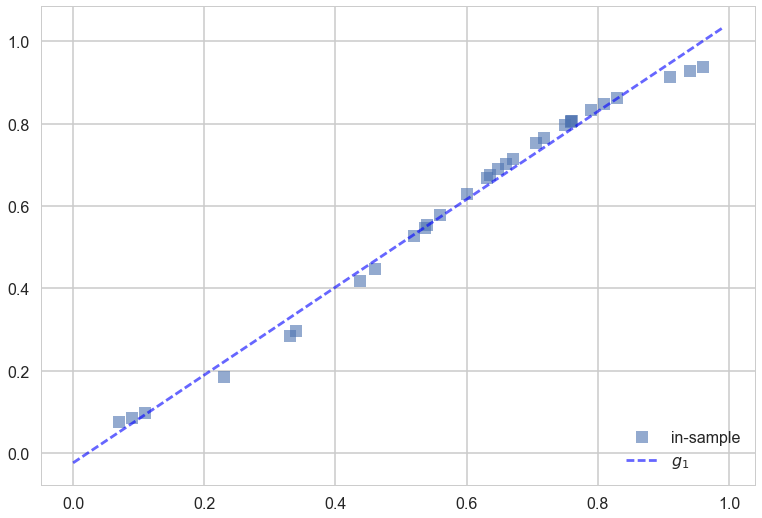

In [8]:
g1 = np.poly1d(np.polyfit(x[indexes],f[indexes],1))
plt.plot(x[indexes],f[indexes], 's', alpha=0.6, label="in-sample");
plt.plot(x,g1(x), 'b--', alpha=0.6, label="$g_1$");
plt.legend(loc=4);

How did we calculate the best fit? We'll come to that in a bit, but in the meanwhile, lets formalize and generalize the notion of "best fit line amongst lines" a bit.

The set of all functions of a particular kind that we could have used to fit the data is called a **Hypothesis Space**. The words "particular kind" are deliberately vague: its our choice as to what we might want to put into a hypothesis space. A hypothesis space is denoted by the notation $\cal{H}$.

Lets consider the hypothesis space of all straight lines $h_1(x)$. We'll denote it as $\cal{H}_1$, with the subscript being used to mark the order of the polynomial. Another such space might be $\cal{H}_2$, the hypothesis space of all quadratic functions. A third such space might combine both of these together. We get to choose what we want to put into our hypothesis space.

In this set-up, what we have done in the code and plot above is this: we have found the best $g_1$ to the data $\cal{D}$ from the functions in the hypothesis space $\cal{H}_1$. This is not the best fit from all possible functions, but rather, the best fit from the set of all the straight lines. 

The hypothesis space is a concept we can use if we want to capture the **complexity** of a model you use to fit data. For example, since quadratics are more complex functions than straight lines (they curve more), $\cal{H}_2$ is more complex than $\cal{H}_1$. 


### Deterministic Error or Bias

Notice from the figure above that models in $\cal{H}_1$, i.e., straight lines, and the best-fit straight line $g_1$ in particular, do not do a very good job of capturing the curve of  the data (and thus the underlying function $f$ that we are trying to approximate. Consider the more general case in the figure below, where a curvy $f$ is approximated by a function $g$ which comes from an $\cal{H}$ that just does not allow the level of wiggling that $f$ has. 

![m:Bias](./images/bias.png)

There is always going to be an error then, in approximating $f$ by $g$. This *approximation error* is shown in the figure by the blue shaded region, and it's called **bias**, or **deterministic error**. The former name comes from the fact that $g$ and other members of $\cal{H}$ just do not wiggle the way $f$ does (nothing will make a straight line curve). The latter name (which I first saw used in http://www.amlbook.com/ ) comes from the notion that if you did not know the target function $f$, which is the case in most learning situations, you would have a hard time distinguishing this error from any other errors such as measurement and noise...

Going back to our model at hand, it is clear that the space of 
straight lines $\cal{H_1}$ does not capture the curving in the data. So let us consider the more complex hypothesis space $\cal{H_{20}}$, the set of all 20th order 
polynomials $h_{20}(x)$:

$$h_{20}(x) = \sum_{i=0}^{20} a_i x^i\,.$$

To see how a more complex hypothesis space does, lets find the best fit 20th order polynomial $g_{20}(x)$.

In [9]:
g20 = np.poly1d(np.polyfit(dfsample["x"],dfsample["f"],20))

C:\Users\Will\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


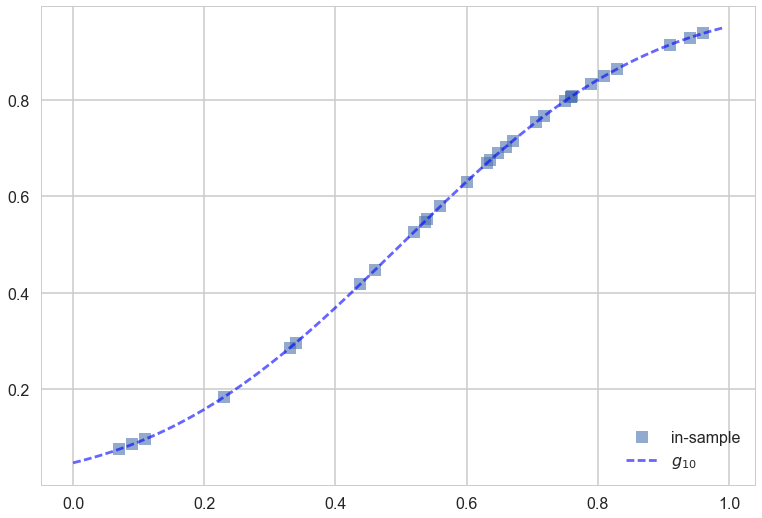

In [10]:
plt.plot(dfsample["x"],dfsample["f"], 's', alpha=0.6, label="in-sample");
plt.plot(x,g20(x), 'b--', alpha=0.6, label="$g_{10}$");
plt.legend(loc=4);

Voila! You can see the 20th order polynomial does a much better job of tracking the points, because of the wiggle room it has in making a curve "go near or through" all the points as opposed to a straight line which, well, can't curve. Thus it would seem that $\cal{H}_{20}$ might be a better candidate hypothesis set from which to choose a best fit model. 

We can quantify this by calculating some notion of the bias for both $g_1$ and $g_{20}$. 
To do this we calculate the square of the difference between f and the g's on the population of 200 points i.e.:

$$B_1(x) = (g_1(x) - f(x))^2 \,;\,\, B_{20}(x) = (g_{20}(x) - f(x))^2\,.$$ 

Squaring makes sure that we are calculating a positive quantity, and punishes large errors more severely than small errors.

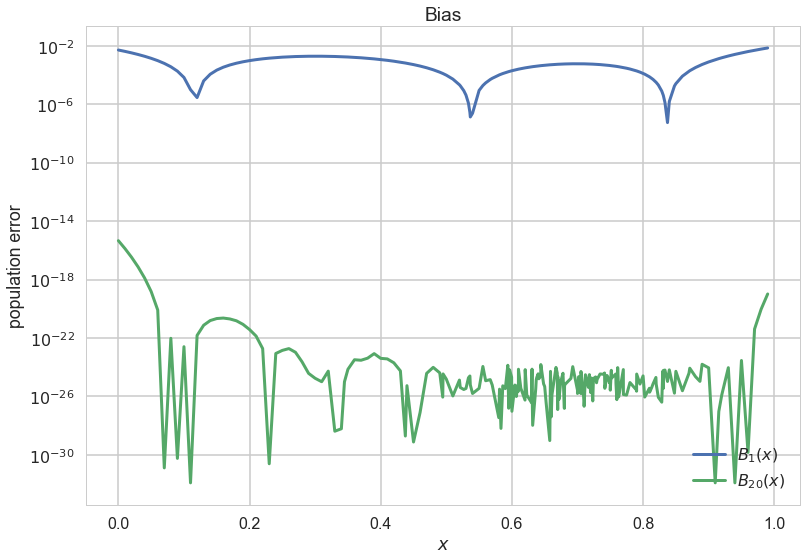

In [11]:
plt.plot(x, (g1(x)-f)**2, lw=3, label="$B_1(x)$")
plt.plot(x, (g20(x)-f)**2, lw=3,label="$B_{20}(x)$");
plt.xlabel("$x$")
plt.ylabel("population error")
plt.yscale("log")
plt.legend(loc=4);
plt.title("Bias");

As you can see the **bias or approximation error** is much smaller for $g_{20}$.

Is $g_{20}$ the best model for this data from all possible models? Indeed, how do we find the best fit model from the best hypothesis space? This is what **learning** is all about.

We have used the python function `np.polyfit` to find $g_{1}$ the best fit model in $\cal{H_1}$ and $g_{20}$ the best fit model in $\cal{H_{20}}$, but how did we arrive at that conclusion? This is the subject of the next section. 

## How to learn the best fit model in a hypothesis space

Let's understand in an intuitive sense, what it means for a function to be a good fit to the data. Lets consider, for now, only the hypothesis space $\cal{H}_{1}$, the set of all straight lines. In the figure below, we draw against the data points (in red) one such line $h_1(x)$ (in red).

You might think you want to do this statistically, using ML Estimation or similar, but note that at this point there is no statistical notion of a generating process. We're just trying to approximate a function by another, with the latter being chosen amongst many in a hypothesis space.

![m:Cost](./images/linreg.png)

The natural way of thinking about a "best fit" would be to minimize the distance from the line to the points, for some notion of distance. In the diagram we depict one such notion of distance: the vertical distance from the points to the line. These distances are represented as thin black lines.

The next question that then arises is this: how exactly we define the measure of this vertical distance? We can't take the measure of distance to be the y-value of the point minus the y value of the line at the same x, ie $y_i - h_1(x_i)$. Why? If we did this, then we could have points very far from the line, and as long as the total distance above was equal to the total distance below the line, we'd get a net distance of 0 even when the line is very far from the points.

Thus we must use a positive estimate of the distance as our measure. We could take either the absolute value of the distance, $\vert y_i - h_1(x_i) \vert$, or the square of the distance as our measure, $(y_i - h_1(x_i))^2$. Both are reasonable choices, and we shall use the squared distance for now. (Now its probably clear to you why we defined bias in the last section as the pointwise square of the distance).

We sum this measure up over all our data points, to create whats known as the **error functional** or **risk functional** (also just called **error**, **cost**, or **risk**) of using line $h_1(x)$ to fit our points $y_i \in \cal{D}$ (this notation is to be read as "$y_i$ in $\cal{D}$") :

$$ R_{\cal{D}}(h_i(x)) = \frac{1}{N} \sum_{y_i \in \cal{D}} (y_i - h_1(x_i))^2 $$

where $N$ is the number of points in $\cal{D}$.

What this formula says is: the cost or risk is just the total squared distance to the line from the observation points. Here we use the word **functional** to denote that, just as in functional programming, the risk is a *function of the function* $h_1(x)$. 

We also make explicit the in-sample data $\cal{D}$, because the value of the risk depends upon the points at which we made our observation. If we had made these observations $y_i$ at a different set of $x_i$, the value of the risk would be somewhat different. The hope in learning is that the risk will not be too different, as we shall see in the next section

Now, given these observations, and the hypothesis space $\cal{H}_1$, we minimize the risk over all possible functions in the hypothesis space to find the **best fit** function $g_1(x)$:

$$ g_1(x) = \arg\min_{h_1(x) \in \cal{H}} R_{\cal{D}}(h_1(x)).$$

Here the notation 

$"\arg\min_{x} F(x)"$ 

means: give me the argument of the functional $x$ at which $F(x)$ is minmized. So, for us: give me the function $g_1(x) = h_1$ at which the risk $R_{\cal{D}}(h_1)$ is minimized; i.e. the minimization is over *functions* $h_1$.

And this is exactly what the python function `np.polyfit(x,h,n)` does for us. It minimizes this squared-error with respect to the coefficients of the polynomial.

Thus we can in general write:

$$ g(x) = \arg\min_{h(x) \in \cal{H}} R_{\cal{D}}(h(x)),$$

where $\cal{H}$ is a general hypothesis space of functions.

### The Structure of Learning

We have a target function $f(x)$ that we do not know. But we do have a sample of data points from it, $(x_1,y_1), (x_2,y_2), ..., (x_n,y_n)$. We call this the **sample** or **training examples** $\cal{D}$. We are interested in using this sample to estimate a function $g$ to approximate the function $f$, and which can be used for prediction at new data points, or on the entire population, also called **out-of-sample prediction**. 

Notice the way that statistics comes into this approximation problem is from the notion that we are trying to reconstruct the original function from a small-ish sample rather than a large-ish population.

To do this, we use an algorithm, called the **learner**, which chooses functions from a hypothesis set $\cal{H}$ and computes a cost measure or risk functional $R$ (like the sum of the squared distance over all points in the data set) for each of these functions. It then chooses the function $g$ which **minimizes** this cost measure amonst all the functions in $\cal{H}$, and thus gives us a final hypothesis $g$ which we then use to approximate or estimate f **everywhere**, not just at the points in our data set. 

Here our learner is called **Polynomial Regression**, and it takes a hypothesis space $\cal{H}_d$ of degree $d$ polynomials, minimizes the "squared-error" risk measure, and spits out a best-fit hypothesis $g_d$.

![](images/BasicModel.png)

### Out-of-Sample and in-sample

We write $g \approx f$, or $g$ is the **estimand** of $f$. In statistics books you will see $g$ written as $\hat{f}$. 

Why do we think that this might be a good idea? What are we really after?

What we'd like to do is **make good predictions**. In the language of cost, what we are really after is to minimize the cost **out-of-sample**, on the **population** at large. But this presents us with a conundrum: *how can we minimize the risk on points we haven't yet seen*?

This is why we (a) minimize the risk on the set of points that we have to find $g$ and then (b) hope that once we have found our best model $g$, our risk does not particularly change out-of-sample, or when using a different set of points

We are, as is usual in statistics, **drawing conclusions about a population from a sample**. 

Intuitively, to do this, we need to ask ourselves, how representative is our sample? Or more precisely, how representative is our sample of our training points of the population (or for that matter the new x that we want to predict for)? 

We illustrate this below for our population of 200 data points and our sample of 30 data points (in green).

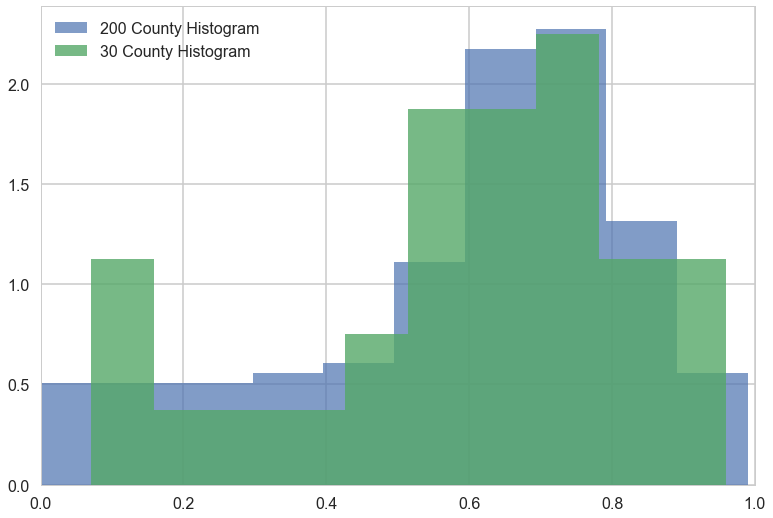

In [12]:
plt.hist(x, normed=True, alpha=0.7)
plt.hist(x[indexes], normed=True, alpha=0.8)
plt.xlim([0,1]);

plt.legend(["200 County Histogram","30 County Histogram"]);

Our sample points seem to follow our (god given) histogram tolerably well.

In our example, if we only want to use $g$, our estimand of $f$ to predict for large $x$, or more religious counties, we would need a good sampling of points $x$ closer to 1. And, similarly, the new $x$ we are using to make predictions would also need to be representative of those counties. We won't do well if we try and predict low-religiousness counties from a sample of high-religiousness ones. Or, if we do want to predict over the entire range of religiousness, our training sample better cover all $x$ well.

### LLN (Maybe) Justifes Estimating Error via the Training Points 

The process of minimization we do is called **Empirical Risk Minimization** (ERM) as we minimize the cost measure over the "empirically observed" training examples or points. But, on the assumption that we  were given a training set representative of the population, ERM is just an attempt use of the Law of Large Numbers.

What we really want to calculate is:

$$R_{out}(h) =  E_{p(x)}[(h(x) - f(x))^2] = \int p(x)  (h(x) - f(x))^2 dx .$$

As usual we do not have access to the population but just some samples and thus we want to do something like:

$$R_{out}(h) = \lim_{n \to \infty} \frac{1}{n} \sum_{x_i \sim p(x)} (h(x_i) - f(x_i))^2 = \lim_{n \to \infty} \frac{1}{n} \sum_{x_i \sim p(x)} (h(x_i) - y_i)^2.$$

We do not have an infinitely large training "sample". On the assumption that its representative (i.e. drawn from $p(x)$) we calculate

$$R_{\cal{D}}(h) =  \sum_{x_i \in \cal{D}} (h(x_i) - y_i)^2.$$

$R_{\cal{D}}(h)$ is, of course, calculated from our dataset and thus varies from dataset to dataset. We could ask questions about how well we know the true value of $R_{\cal{D}}(h)$, but LLN assures us that if the values in the sum aren't too badly behaved $R_{\cal{D}}(h)$ won't be too different from sample to sample. [Though whether $R_{\cal{D}}(h)$ actually closes in on out-of-sample performance will change when we include noise in the data]

With the above justification, we can say that, if we find a hypothesis $g$ that minimizes the cost or risk over the training set, this hypothesis *might* do a good job over the population that the training set was representative of, since the risk on the population ought to be similar to that on the training set, and thus small.

Mathematically, we are saying that:

$$
\begin{eqnarray*}
A &:& R_{\cal{D}}(g) \,\,smallest\,on\,\cal{H}\\
B &:& R_{out} (g) \approx R_{\cal{D}}(g)
\end{eqnarray*}
$$

In other words, we hope the **empirical risk estimates the out of sample risk well, and thus the out of sample risk is also small**. In the noiseless case, we believe this will be true when training samples are large enough to mostly mirror the population at large.

Indeed, as we can see below, our champion model $g_{20}$ does an excellent job on the population, not just on the sample.

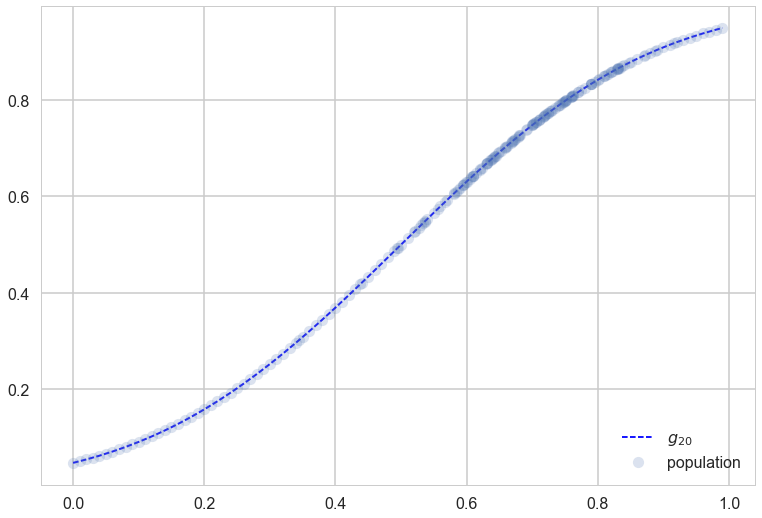

In [13]:
plt.plot(x,g20(x), 'b--', alpha=0.9, lw=2, label="$g_{20}$");
plt.plot(x,f, 'o', alpha=0.2, label="population");
plt.legend(loc=4);